# Braille-लिपी

In [1]:
# Install the kaggle library
!pip install -q kaggle

# Upload the Kaggle API keys
from google.colab import files
files.upload()

!mkdir ~/.kaggle

# Copy the json file to the folder
!cp kaggle.json ~/.kaggle

# Change permissions for keys to work with the Kaggle API
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d shanks0465/braille-character-dataset

Saving kaggle.json to kaggle.json
  0% 0.00/1.30M [00:00<?, ?B/s]
100% 1.30M/1.30M [00:00<00:00, 50.2MB/s]


In [2]:
# Getting the helper functions script
!wget https://raw.githubusercontent.com/ishandandekar/Looking_Fruit/main/scripts/helper_functions.py

# Get the necessary functions from the python script
from helper_functions import plot_loss_curves, unzip_data, create_model_checkpoint, create_early_stopping, get_metrics

--2022-10-28 17:30:30--  https://raw.githubusercontent.com/ishandandekar/Looking_Fruit/main/scripts/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3282 (3.2K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   3.21K  --.-KB/s    in 0s      

2022-10-28 17:30:30 (50.1 MB/s) - ‘helper_functions.py’ saved [3282/3282]



In [3]:
# Unzip data
unzip_data('braille-character-dataset.zip', data_dir="raw")

In [4]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Accuracy, Precision, Recall

In [5]:
# Defining paths
BASE_DATA_DIR = '/content/raw/Braille Dataset/Braille Dataset'

if not os.path.exists(os.path.join('/content/', 'data')):
  os.mkdir('./data')
  alpha = 'a'
  for i in range(0, 26): 
      os.mkdir('./data/' + alpha)
      alpha = chr(ord(alpha) + 1)

for file in os.listdir(BASE_DATA_DIR):
    letter = file[0]
    copyfile(os.path.join(BASE_DATA_DIR, file),os.path.join(os.path.join('data', letter), file))

In [32]:
img = mpimg.imread('/content/data/a/a1.JPG0dim.jpg')
img.shape

(28, 28, 3)

In [6]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=20,
                             shear_range=10,
                             validation_split=0.2)

train_generator = datagen.flow_from_directory('./data/',
                                              target_size=(28,28),
                                              subset='training')

val_generator = datagen.flow_from_directory('./data/',
                                            target_size=(28,28),
                                            subset='validation')

Found 1248 images belonging to 26 classes.
Found 312 images belonging to 26 classes.


In [7]:
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.regularizers import l2

In [9]:
# Setting random seed
tf.random.set_seed(42)

# Creating the model
model_0 = tf.keras.Sequential([
    layers.Input(shape=(28,28,3)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(26,activation='softmax')
])

# Compiling the model
model_0.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fitting the model
history_0 = model_0.fit(train_generator, validation_data=val_generator, epochs=10)

Epoch 1/10
39/39 [==============================] - 4s 69ms/step - loss: 38.6296 - accuracy: 0.0321 - val_loss: 3.2582 - val_accuracy: 0.0385
Epoch 2/10
39/39 [==============================] - 2s 51ms/step - loss: 3.4035 - accuracy: 0.0401 - val_loss: 3.2582 - val_accuracy: 0.0385
Epoch 3/10
39/39 [==============================] - 1s 35ms/step - loss: 3.2585 - accuracy: 0.0385 - val_loss: 3.2582 - val_accuracy: 0.0385
Epoch 4/10
39/39 [==============================] - 1s 25ms/step - loss: 3.2586 - accuracy: 0.0345 - val_loss: 3.2582 - val_accuracy: 0.0385
Epoch 5/10
39/39 [==============================] - 1s 29ms/step - loss: 3.2585 - accuracy: 0.0353 - val_loss: 3.2582 - val_accuracy: 0.0385
Epoch 6/10
39/39 [==============================] - 1s 29ms/step - loss: 3.2586 - accuracy: 0.0361 - val_loss: 3.2582 - val_accuracy: 0.0385
Epoch 7/10
39/39 [==============================] - 1s 24ms/step - loss: 3.2585 - accuracy: 0.0353 - val_loss: 3.2582 - val_accuracy: 0.0385
Epoch 8/10
3

In [9]:
# Setting random seed
tf.random.set_seed(42)

# Creating the model
model_0 = tf.keras.Sequential([
    layers.Input(shape=(28,28,3)),
    layers.Resizing(256, 256),
    layers.Conv2D(64,(3,3),activation='relu', name="first"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3),activation='relu', name="second"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3),activation='relu', name="third"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,(2,2),activation='relu', name="last"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256,kernel_regularizer=l2(2e-4)),
    layers.LeakyReLU(),
    layers.Dense(64,kernel_regularizer=l2(2e-4)),
    layers.LeakyReLU(),
    layers.Dense(26,activation='softmax')
])

# Compiling the model
model_0.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Setting up callbacks
model_ckpt = tf.keras.callbacks.ModelCheckpoint('BrailleNet.h5',save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=8,verbose=0)
early_stop = tf.keras.callbacks.EarlyStopping(patience=15,verbose=1)

# Fitting the model
history_0 = model_0.fit(train_generator, validation_data=val_generator, epochs=60, callbacks=[early_stop, model_ckpt, reduce_lr])

Epoch 1/60
39/39 [==============================] - 6s 141ms/step - loss: 12.0249 - accuracy: 0.0465 - val_loss: 3.3680 - val_accuracy: 0.0449 - lr: 0.0010
Epoch 2/60
39/39 [==============================] - 5s 134ms/step - loss: 3.3011 - accuracy: 0.0889 - val_loss: 3.0143 - val_accuracy: 0.2372 - lr: 0.0010
Epoch 3/60
39/39 [==============================] - 5s 134ms/step - loss: 2.4850 - accuracy: 0.3942 - val_loss: 2.2813 - val_accuracy: 0.4936 - lr: 0.0010
Epoch 4/60
39/39 [==============================] - 5s 134ms/step - loss: 1.9391 - accuracy: 0.5585 - val_loss: 1.8555 - val_accuracy: 0.5865 - lr: 0.0010
Epoch 5/60
39/39 [==============================] - 5s 135ms/step - loss: 1.5735 - accuracy: 0.6290 - val_loss: 1.6216 - val_accuracy: 0.6699 - lr: 0.0010
Epoch 6/60
39/39 [==============================] - 5s 134ms/step - loss: 1.3824 - accuracy: 0.6859 - val_loss: 1.5885 - val_accuracy: 0.6827 - lr: 0.0010
Epoch 7/60
39/39 [==============================] - 5s 134ms/step - l

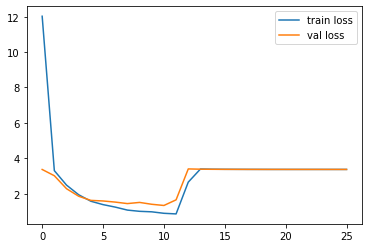

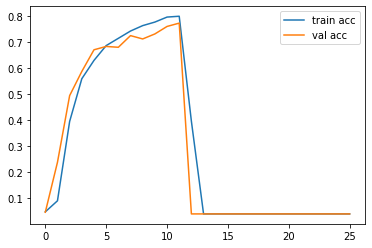

<Figure size 432x288 with 0 Axes>

In [10]:
plt.plot(history_0.history['loss'], label='train loss')
plt.plot(history_0.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history_0.history['accuracy'], label='train acc')
plt.plot(history_0.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [11]:
from tensorflow.keras.models import load_model
model_0_saved = load_model('BrailleNet.h5')
model_0_saved.evaluate(val_generator)

10/10 [==============================] - 1s 53ms/step - loss: 1.3145 - accuracy: 0.7532


[1.3145058155059814, 0.7532051205635071]

In [12]:
# 0. Set random seed
tf.random.set_seed(42)
INPUT_SHAPE = (28,28,3)

# 1. Create the model
base_efficient_net_model=tf.keras.applications.EfficientNetB3(include_top=False)
base_efficient_net_model.trainable=False
inputs= layers.Input(shape=INPUT_SHAPE, name="input_layer")
scaled = layers.Resizing(64, 64)(inputs)
x = base_efficient_net_model(scaled)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs=tf.keras.layers.Dense(26,activation="softmax",name="output_layer")(x)
model_1 = tf.keras.Model(inputs=inputs, outputs=outputs, name="model_4_freezed_EfficientNet")

# 2. Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=['accuracy'])

# Fitting the model
history_1 = model_1.fit(train_generator, validation_data=val_generator, epochs=60, callbacks=[early_stop, model_ckpt, reduce_lr])

43941136/43941136 [==============================] - 0s 0us/step
Epoch 1/60
39/39 [==============================] - 15s 121ms/step - loss: 3.1557 - accuracy: 0.0905 - val_loss: 2.8327 - val_accuracy: 0.2019 - lr: 0.0010
Epoch 2/60
39/39 [==============================] - 2s 44ms/step - loss: 2.7484 - accuracy: 0.2075 - val_loss: 2.5731 - val_accuracy: 0.2981 - lr: 0.0010
Epoch 3/60
39/39 [==============================] - 2s 44ms/step - loss: 2.5342 - accuracy: 0.2845 - val_loss: 2.4184 - val_accuracy: 0.2981 - lr: 0.0010
Epoch 4/60
39/39 [==============================] - 2s 45ms/step - loss: 2.3932 - accuracy: 0.2997 - val_loss: 2.2850 - val_accuracy: 0.3782 - lr: 0.0010
Epoch 5/60
39/39 [==============================] - 2s 43ms/step - loss: 2.2423 - accuracy: 0.3590 - val_loss: 2.1358 - val_accuracy: 0.4135 - lr: 0.0010
Epoch 6/60
39/39 [==============================] - 2s 44ms/step - loss: 2.1465 - accuracy: 0.3990 - val_loss: 2.0569 - val_accuracy: 0.3878 - lr: 0.0010
Epoch 7/6

In [ ]:
# 0. Set random seed
tf.random.set_seed(42)
INPUT_SHAPE = (28,28,3)

# 1. Create the model
base_efficient_net_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_efficient_net_model.trainable=False

# Setting the base model to train (only on the last 10 layers)
LAYERS_TRAINABLE = 15
for layer in base_efficient_net_model.layers[-LAYERS_TRAINABLE:]:
  layer.trainable = True

inputs= layers.Input(shape=INPUT_SHAPE, name="input_layer")
scaled = layers.Resizing(64, 64)(inputs)
x = base_efficient_net_model(scaled)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs=tf.keras.layers.Dense(26,activation="softmax",name="output_layer")(x)
model_2 = tf.keras.Model(inputs=inputs, outputs=outputs, name="model_6_finetuned_EfficientNet")

# 2. Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=['accuracy'])

# Fitting the model
history_2 = model_2.fit(train_generator, validation_data=val_generator, epochs=60, callbacks=[early_stop, model_ckpt, reduce_lr])

In [20]:
from tensorflow.keras.models import load_model
model_2_saved = load_model('BrailleNet.h5')
model_2_saved.evaluate(val_generator)

10/10 [==============================] - 0s 28ms/step - loss: 0.4813 - accuracy: 0.8846


[0.48129400610923767, 0.8846153616905212]

In [25]:
from PIL import Image
import tensorflow as tf
import numpy as np

In [15]:
def load_and_prep_image(filename: Image,img_shape=28):
    img = np.array(filename)
    img = tf.cast(img,tf.float32)
    img = tf.image.resize(img, [img_shape, img_shape])
    img = tf.keras.utils.array_to_img(img)
    return img

In [32]:
!pip install --upgrade Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 33.0 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


In [28]:
# Upload the Kaggle API keys
from google.colab import files
files.upload()

Saving IMG20221028223154.jpg to IMG20221028223154.jpg


{'IMG20221028223154.jpg': b'\xff\xd8\xff\xe1\x00\x16Exif\x00\x00MM\x00*\x00\x00\x00\x08\x00\x00\x00\x00\x00\x00\xff\xe2\x02(ICC_PROFILE\x00\x01\x01\x00\x00\x02\x18\x00\x00\x00\x00\x02\x10\x00\x00mntrRGB XYZ \x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00acsp\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\xf6\xd6\x00\x01\x00\x00\x00\x00\xd3-\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\tdesc\x00\x00\x00\xf0\x00\x00\x00trXYZ\x00\x00\x01d\x00\x00\x00\x14gXYZ\x00\x00\x01x\x00\x00\x00\x14bXYZ\x00\x00\x01\x8c\x00\x00\x00\x14rTRC\x00\x00\x01\xa0\x00\x00\x00(gTRC\x00\x00\x01\xa0\x00\x00\x00(bTRC\x00\x00\x01\xa0\x00\x00\x00(wtpt\x00\x00\x01\xc8\x00\x00\x00\x14cprt\x00\x00\x01\xdc\x00\x00\x00<mluc\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x0cenUS\x00\x00\x00X\x00\x

In [27]:
image_path = r"/content/IMG20221028223154.jpg"
img = Image.open(image_path)
print(img.size)
var = load_and_prep_image(img)
type(var)

(3000, 4000)


PIL.Image.Image

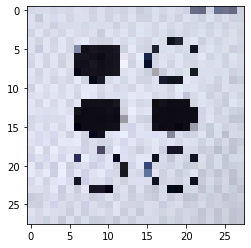

In [23]:
import matplotlib.pyplot as plt
plt.imshow(var)